# Libraries

In [ ]:
 !pip install plotly --upgrade
 !pip install emoji --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.12.0)
Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.6.0)


In [ ]:
import warnings,os
from google.colab import drive  

import numpy as np
import pandas as pd

from tabulate import tabulate

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS

import emoji

from sklearn.utils import class_weight

warnings.filterwarnings('ignore')

# Dataset

### Access Google Colab

In [ ]:
drive.mount(r'/content/drive/',force_remount=True) 

filename = 'accidental_sessions_data.parquet'
data_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/NLP/Project/data/'
data_dir

### Read Dataset

In [ ]:
dataset_file = 'accidental_sessions_data.parquet'

df = pd.read_parquet(data_dir+dataset_file)
df.sample(10)

,message,label
11254,So your not gonna try to fix whatever software...,0
17733,"Hi there, I want to remove Sprint complete pro...",0
3142,How do I back up my phone?,0
35684,How do I activate my new phone?,0
28117,Rondale cutler,0
28776,Hello,0
13268,Hi! Can you help me get started with my new ph...,0
4974,"Ever since the merger completion, my data down...",0
2038,Dual screen cover broke,0
39412,Hi I would like to cancel my sprint complete o...,0


### Getting a "feel" of the words


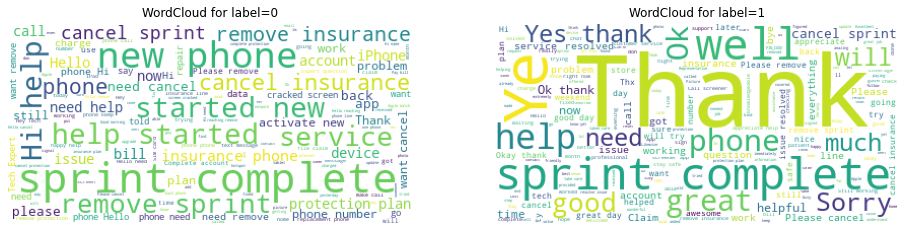

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (16,6))

for l in df.label.unique():
    words = df.message[df.label==l]
    wc = WordCloud(background_color = 'white',stopwords=set(STOPWORDS)).generate(' '.join(words))
    ax[l].imshow(wc)
    ax[l].set_title('WordCloud for label='+str(l))
    ax[l].axis('off')

plt.axis('off')
plt.show()

# Imbalanced


In [ ]:
fig = px.histogram(df, x="label")
fig.update_layout(autosize=False,width=400,height=400,bargap=0.6)
fig.show()

# Message Length

### Create Feature

In [ ]:
df['message_length'] = df.message.str.len()

### relationship between label and the number of characters in message

In [ ]:
fig = px.box(df, x="message_length", color="label")
# fig.update_layout(autosize=False,width=900,height=600)
fig.show(renderer="colab")

### Look at "short" messages

In [ ]:
fig = px.histogram(df, x="message_length", color="label")
fig.update_layout(xaxis=dict(range=[0, 50]),bargap=0.1)
fig.show()

Obviously, the shorter the massage - the less information - the harder the task.

note to self:

  - get the context

  - get a flag of new user

  - get demographic information (and if english speaker)

  - etc.

  <br><br><br>

### Short Massages by label

In [ ]:
df[df.message_length==1][['message','label']].groupby(by=['label','message']).size().unstack(fill_value=0)

message,.,1,2,3,5,7,?,A,E,H,I,J,K,M,S,T,U,W,Y,Z,✊,￼,👍,💩,😊,😔,🙏
label,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,7,3,0,2,0,17,3,1,4,1,2,5,3,1,1,1,1,0,2,1,1,4,1,1,1,1
1,0,6,4,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


Very intresting...

note to self: there r prb tagging errors.
<br><br>

In [ ]:
df[df.message_length==2][['message','label']].groupby(by=['label','message']).size().unstack(fill_value=0)

message,\n1,*2,.,..,1\n,10,11,4g,5g,:),?\n,??,FU,GB,Gi,HI,He,Hi,Hl,I,Im,Ji,Me,NO,Na,No,Np,OK,Ok,On,Pc,TY,Tv,Ty,U2,Up,XR,YW,bu,hi,ho,hu,no,oh,ok,sa,so,tc,ty,u2,ye,👋,👍🏻,👍🏾,👍👍
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,1,0,0,1,1,2,1,4,1,0,1,7,1,298,1,1,1,1,1,2,1,42,0,0,50,0,1,1,1,6,0,0,1,1,1,82,1,1,13,1,18,1,1,1,6,0,0,2,1,1,0
1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,36,1,0,0,0,3,3,1,0,0,0,0,0,0,0,0,4,0,0,0,0,2,1,0,0,0,1


In [ ]:
df[df.message_length==3][['message','label']].groupby(by=['label','message']).size().unstack(fill_value=0)

message,3g,!!,...,888,8am,???,App,Bye,DO,Dan,End,Gm,Gus,HI,Hai,Hay,Hep,Heu,Hey,Hi\n,Hi,Hi!,"Hi,",Hi-,Hi.,Hii,Hiw,How,Huh,Ian,Lol,My,Nat,No,No.,Noo,OK!,Ok\n,Ok,Ok.,...,Pay,Psk,S20,S9+,Sam,So?,Sup,Thx,Ty,Ty⚘,U 2,VPN,Vpn,Wow,Wtf,XXX,Xr,YES,Yea,Yes,Yez,Ywa,bye,dan,hey,hi\n,hi,hi!,hii,no,noi,thx,tks,u 2,wow,yes,you,👋🏻,👍👍👍,🤣🤣🤣
label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,2,1,2,1,3,1,0,1,1,1,4,1,1,0,1,46,3,66,7,1,1,2,4,1,2,1,1,1,1,0,7,0,1,0,1,12,0,...,1,1,0,1,1,1,0,2,1,0,0,1,1,1,1,0,1,0,1,43,1,1,2,1,4,1,11,1,3,1,1,0,1,1,0,24,1,1,1,1
1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,2,4,2,...,0,0,1,0,0,0,1,4,0,1,2,0,0,0,0,1,0,1,0,47,0,0,2,0,0,0,0,0,0,0,0,1,0,0,1,9,1,0,0,0


In [ ]:
df[df.message_length==10][['message','label']].groupby(by=['label','message']).size().unstack(fill_value=0).iloc[0:2,-12:]

message,thank u :),thank you,thank you!,thank you.,thank ypou,thanks Joe,thanks you,that's all,thats all,thats all?,yes please,you too ty
label,,,,,,,,,,,,
0,2,9,3,0,1,1,1,1,3,1,1,1
1,0,6,0,1,0,0,0,0,0,0,0,0


### notes 
There are probably some tagging errors.  
We probably need to construct a new gold standard corpus.
<br><br><br><br>


# Message Words Length

### Create Feature

In [ ]:
df['message_nwords'] = df.message.str.split().apply(len)
df.head()

,message,label,message_length,message_nwords
0,"not sure, still in progress",1,27,5
1,Yes,1,3,1
2,How can I increase my mbps,1,26,6
3,I have had to call every single month to take ...,0,219,47
4,Hi! Can you help me get started with my new ph...,0,50,11


### Relationship between label and number of words in message

In [ ]:
fig = px.box(df, x="message_nwords", color="label")
fig.update_layout(autosize=False,width=900,height=600)
fig.show()

### Look at "short" messages

In [ ]:
fig = px.histogram(df, x="message_nwords", color="label")
fig.update_layout(xaxis=dict(range=[0, 20]),bargap=0.1)
fig.show()

# Initial Data Preperation

## Emojis


### The Problem

In [ ]:
df[df.message_nwords==1].groupby(by=['label','message']).size().unstack(fill_value=0).iloc[0:2,-10:]

message,👍🏻,👍🏾,👍👍,👍👍👍,💩,😊,😔,😷😷🥰🥰,🙏,🤣🤣🤣
label,,,,,,,,,,
0,1,1,0,1,1,1,1,1,1,1
1,0,0,1,0,0,0,0,0,0,0


### Optimal Solution
In order to get the optimal results I'll probably use the Emoji2Vec package.
And add these embeddings to the BERT embeddings.


### Quick Solution
Decode the emojis to words with the emoji package

In [ ]:
df.message = df.message.apply(lambda x: emoji.demojize(x).replace(':','').replace('_',' '))

## Data Augmentation
Using text augmentation techniques to create more data.

- Thesaurus 
- Word Embeddings
- Back Translation
- Text Generation  
or just Using nlpaug :)


**I'm not using these techniques due to the difficulty to classify "short" messages, and due the popular usage of UNKNOWN tokens...**

## Oversampling and Undersampling

This technique would ease off the imbalance, without doing a lot of work...

I would use the imblearn package **after tokenizing**, and perform Over-sampling (SMOTE) followed by under-sampling(Tomek links).


```
from imblearn.combine import SMOTETomek
smt = SMOTETomek(ratio='minority',n_jobs=-1)
X, y = smt.fit_sample(X_tokens, y)
```

But again my real problem is in the "short" messages...

# Split - Train, Valid, Test

In [ ]:
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

train.to_csv('train.csv')
valid.to_csv('valid.csv')
test.to_csv('test.csv')

df.shape, train.shape,valid.shape,test.shape

((41890, 4), (25134, 4), (8378, 4), (8378, 4))

# Class Weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(df.label),df.label)
class_weights[1] = class_weights[1]*5
class_weights

array([ 0.52363809, 55.38075093])